In [27]:
from expert_data import*
from rl_utils import* 

env_name = 'CartPole-v1'
env = gym.make(env_name)
env.reset(seed=0)
torch.manual_seed(0)
random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

expert_agent,return_list=train_expert_agent(env)

Iteration 9: 100%|██████████| 25/25 [00:03<00:00,  7.91it/s, episode=245, return=488.800]


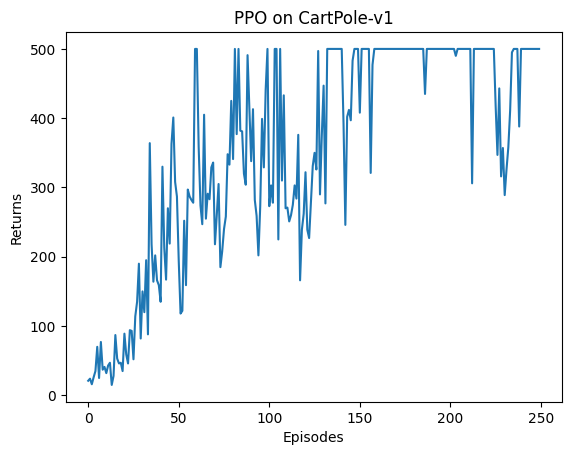

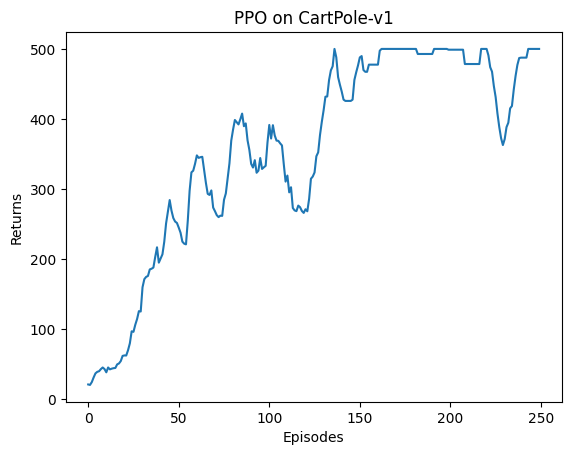

In [28]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [29]:
n_episode = 20
print("Sampling expert data...")
expert_trajectories = sample_expert_data(env, expert_agent, n_episode)

Sampling expert data...


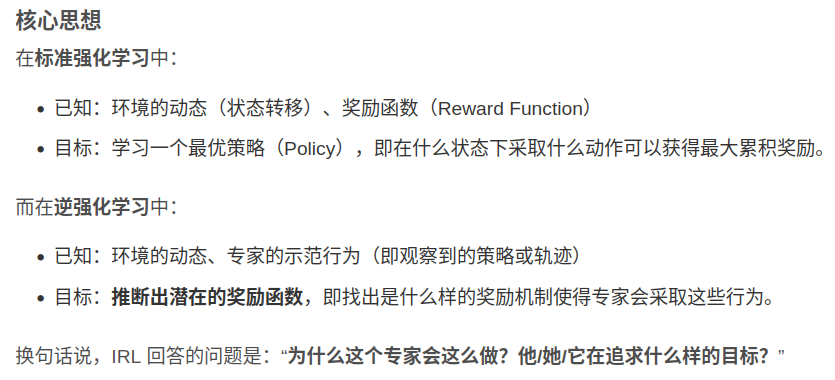  
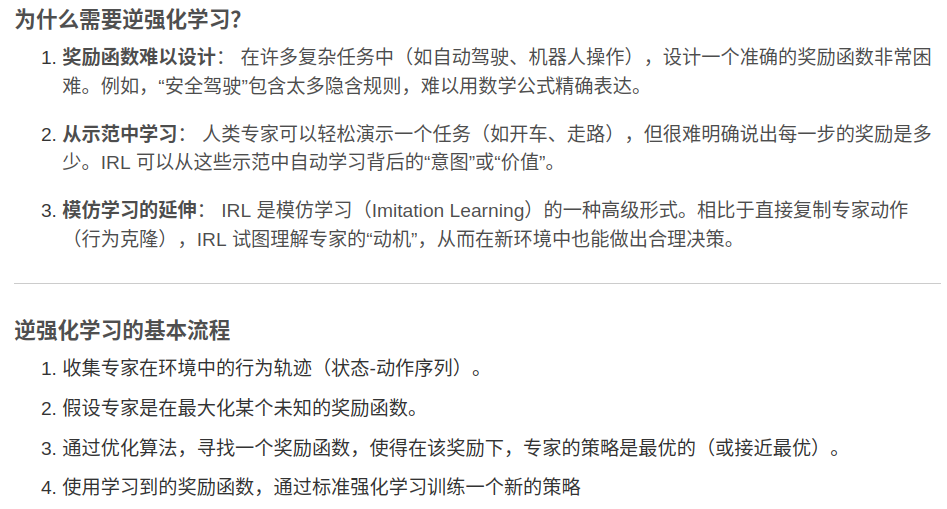

方法分类  
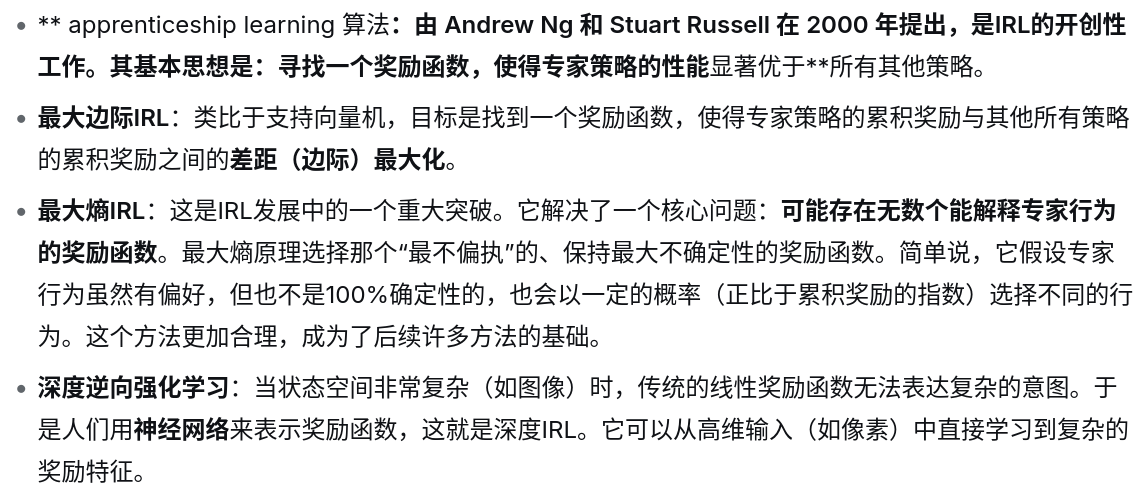

Apprenticeship Learning是思想框架，而最大边际IRL、最大熵IRL等等是其实现手段  
最大边际IRL、最大熵IRL都假设奖励函数是特征向量的线性组合  

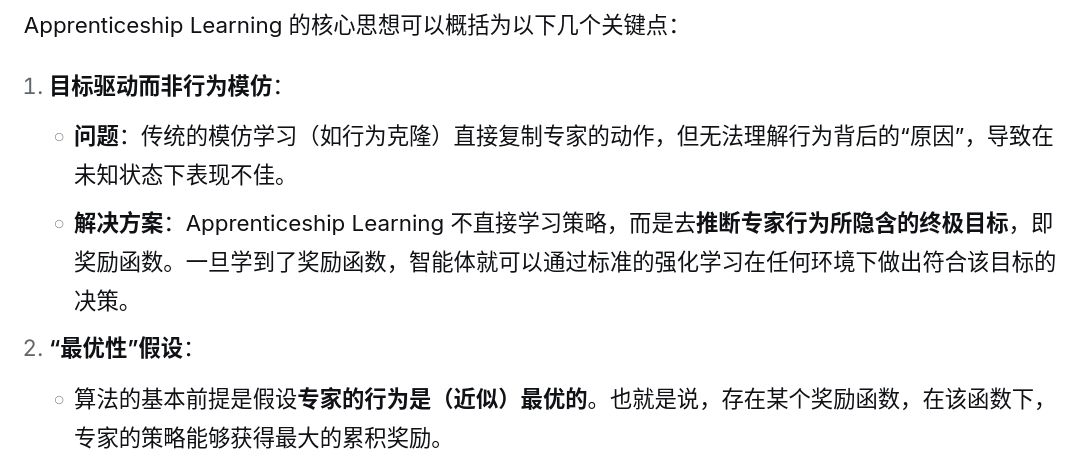  
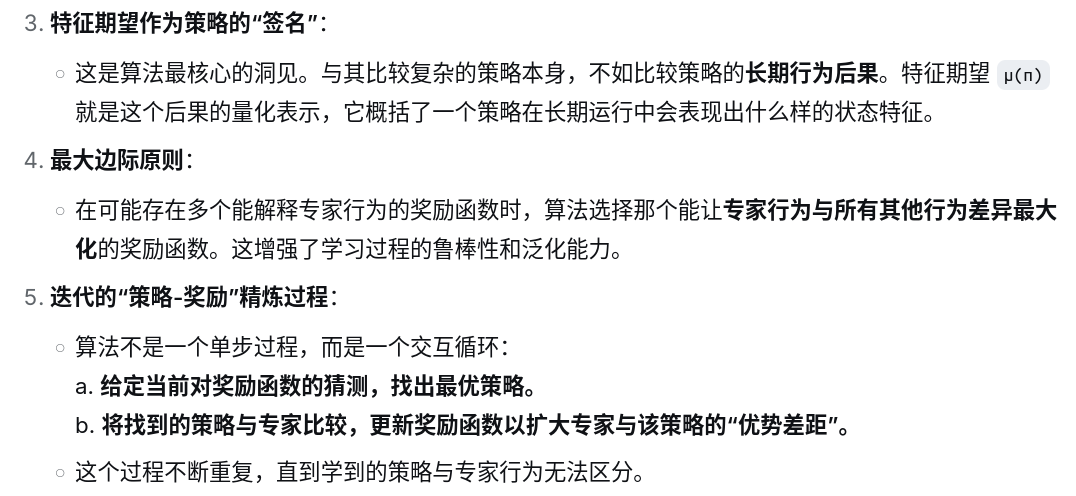

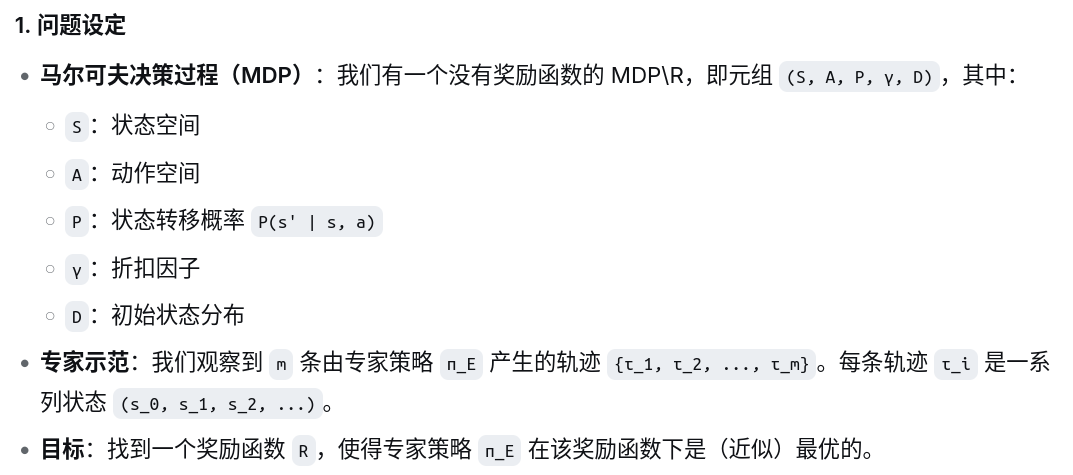  
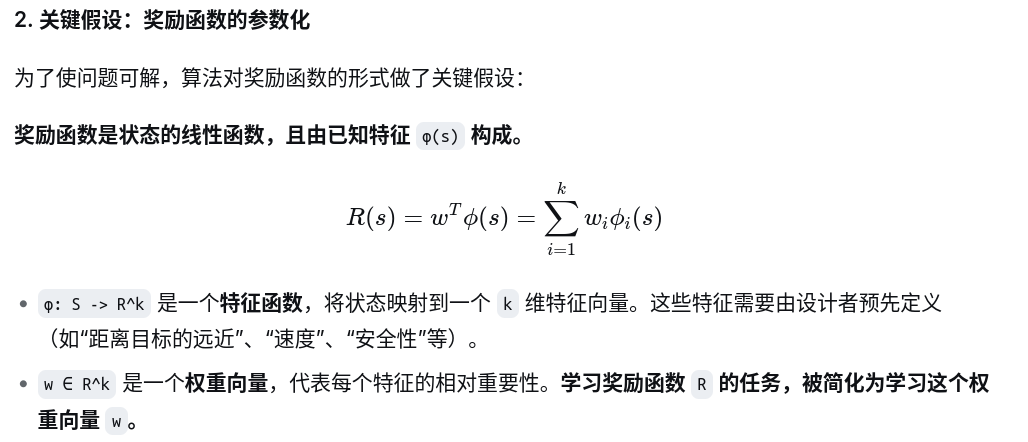  
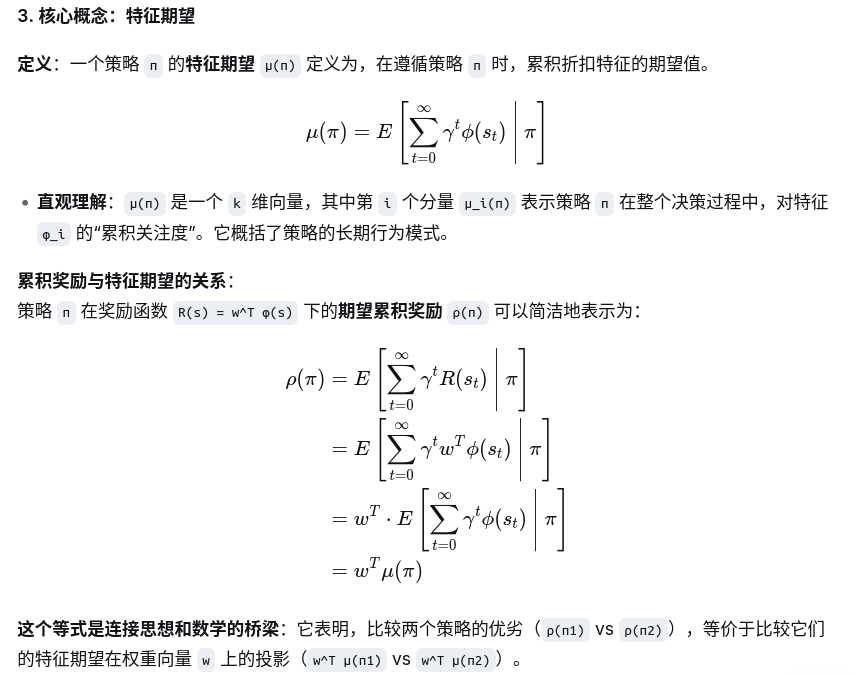

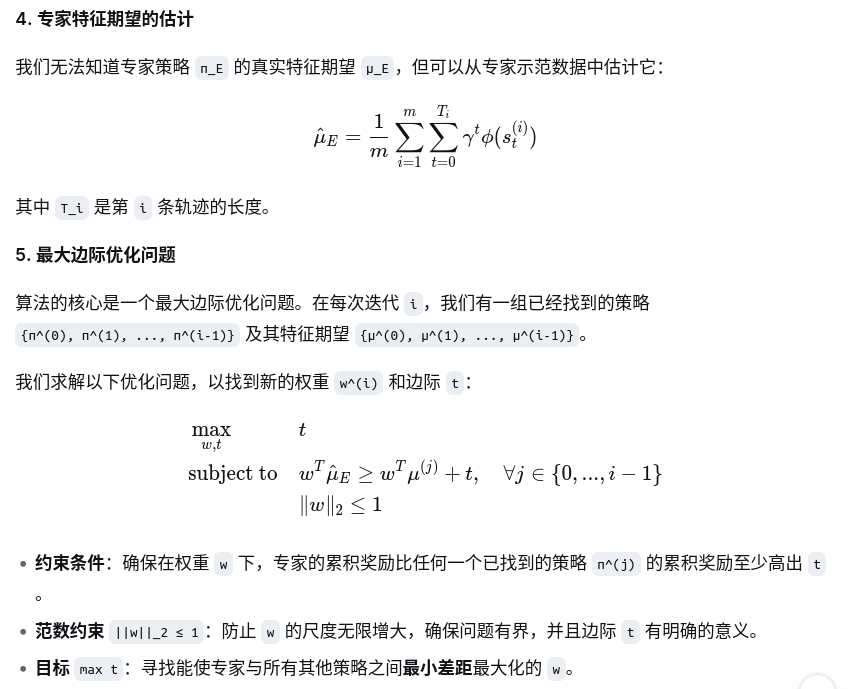  
也就是$t<=w^T(\mu_E-\mu^{(j)})$,t最大就是取等号的情况，应该最大化$w^T(\mu_E-\mu^{(j)})$,对于任意的j  
等价转换
$$\underset{w}{max}\underset{j}{min} \quad w^T(\mu_E-\mu^{(j)})$$
subject to:
$$||w||<1$$
使用支持向量机的方法，特征向量是做分类的超平面的基向量，而权重就是以上问题的权重  
也就是做了一个二分类，使用超平面来分隔开$\mu_E \text{和}\underset{j}{min}\mu^{(j)}$



In [ ]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
import torch.optim as optim

class ApprenticeshipLearning:
    def __init__(self, state_dim, hidden_dim, action_dim, expert_trajectories,
                 actor_lr, critic_lr, lmbda, epochs, eps, gamma, device, n_features=None):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.expert_trajectories = expert_trajectories
        self.device = device
        self.gamma = gamma
        
        # 如果未指定特征维度，使用状态维度
        if n_features is None:
            n_features = state_dim
        self.n_features = n_features
        
        # 初始化PPO agent用于策略学习
        self.ppo_agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                            lmbda, epochs, eps, gamma, device)
        
        # 存储特征期望
        self.expert_feature_expectations = None
        self.learned_policies_feature_expectations = []
        
        # 初始化权重
        self.weights = np.random.normal(size=self.n_features)
        self.weights /= np.linalg.norm(self.weights)  # 归一化
        
        # 特征标准化器
        self.scaler = StandardScaler()
        self._fit_scaler()
    
    def _fit_scaler(self):
        """用专家数据拟合标准化器"""
        all_states = []
        for trajectory in self.expert_trajectories:
            all_states.extend(trajectory['states'])
        if all_states:
            self.scaler.fit(np.array(all_states))
    
    def feature_vector(self, state):
        """计算特征向量"""
        if len(state.shape) == 1:
            state = state.reshape(1, -1)
        return self.scaler.transform(state)
    
    def compute_trajectory_feature_expectations(self, trajectories):
        """计算轨迹集的特征期望 - 按轨迹计算"""
        trajectory_features = []
        for trajectory in trajectories:
            states = trajectory['states']
            discount = 1.0
            features = self.feature_vector(states)
            discounted_features=np.zeros(features.shape[1])
            # 特征向量形状为(episode_num_step,feature_dim)
            # 计算折扣累积特征
            # (feature_dim,)
            # 计算单条轨迹的折扣累积特征
            for i in range(len(features)):
                discounted_features += discount * features[i]
                discount *= self.gamma
            # 轨迹的累积特征向量
            trajectory_features.append(discounted_features)
        if not trajectory_features:
            return np.zeros(self.n_features)
        # 所有轨迹特征向量的均值
        return np.mean(trajectory_features, axis=0)
    
    def compute_reward(self, state):
        """根据当前权重计算奖励"""
        features = self.feature_vector(state)
        reward = np.dot(features, self.weights)
        return reward
    
    def update_weights(self):
        """使用最大边际方法更新权重"""
        if len(self.learned_policies_feature_expectations) == 0:
            return 0
        # 准备数据：专家为正类，学到的策略为负类
        # (collected_num,feature_dim)
        X = np.array(self.learned_policies_feature_expectations)
        # (collected_num,1)
        y = -1 * np.ones(len(X))  # 学到的策略标记为负类
        # 添加专家特征期望
        # (       1,     feature_dim)  
        # (collected_num,feature_dim)
        X_with_expert = np.vstack([self.expert_feature_expectations, X])
        y_with_expert = np.hstack([1.0, y])  # 专家标记为正类
        # 使用线性SVM求解最大边际问题
        svm = LinearSVC(C=1.0, fit_intercept=False, max_iter=10000, tol=1e-4)
        # 输入的第一个参数是数据，第二个数据是类别(0和1)
        svm.fit(X_with_expert, y_with_expert)
        # 更新权重
        self.weights = svm.coef_.flatten()
        # 计算边际
        # 返回每个样本到决策超平面的有符号距离(collected_num+1,)
        decision_values = svm.decision_function(X_with_expert)
        # 第一个是标签为1的专家数据到决策平面的距离
        margin = decision_values[0] - np.max(decision_values[1:])
        # 代表历史策略中与专家策略最近的距离
        return margin
    
    def train(self, env, num_iterations=10, num_policy_trajectories=10, 
              eval_episodes=5, convergence_threshold=0.01):
        """训练Apprenticeship Learning算法"""
        # 计算专家特征期望（按轨迹计算）
        self.expert_feature_expectations = self.compute_trajectory_feature_expectations(
            self.expert_trajectories)
        returns = []
        margins = []
        for iteration in tqdm(range(num_iterations)):
            # 1. 使用当前奖励函数训练PPO agent
            iteration_returns = self.train_agent_with_custom_reward(
                env, num_episodes=num_policy_trajectories)
            returns.append(iteration_returns)
            # 2. 使用训练好的策略收集轨迹数据
            policy_trajectories = self.collect_policy_trajectories(env, eval_episodes)
            # 3. 计算学到的策略的特征期望（按轨迹计算）
            policy_feature_expectations = self.compute_trajectory_feature_expectations(
                policy_trajectories)
            self.learned_policies_feature_expectations.append(policy_feature_expectations)
            # 4. 更新权重
            margin = self.update_weights()
            margins.append(margin)
        
            # 检查收敛
            if margin < convergence_threshold and margin > 0 and iteration > 5:
                print(f"Converged at iteration {iteration+1} with margin {margin:.4f}")
                break
        return returns, margins
    
    def train_agent_with_custom_reward(self, env, num_episodes):
        """使用自定义奖励函数训练PPO"""
        buffer_size = 10000
        minimal_size= 500
        batch_size = 64
        replay_buffer = rl_utils.ReplayBuffer(buffer_size)
        return_list = []
        for episode in range(num_episodes):
            state = env.reset()[0]
            done = False
            while not done:
                action = self.ppo_agent.take_action(state)
                next_state, _, done, truncated, _ = env.step(action)
                done = done or truncated
                # 使用学到的奖励函数
                reward = self.compute_reward(state)
                replay_buffer.add(state, action, reward, next_state, done)
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {'states': b_s, 'actions': b_a, 'next_states': b_ns, 'rewards': b_r, 'dones': b_d}
                    # 更新PPO agent  
                    self.ppo_agent.update(transition_dict)
                state = next_state
        return_list=self.evaluate(env)
        return return_list
    
    def collect_policy_trajectories(self, env, num_episodes):
        """收集策略的轨迹数据（保留轨迹结构）"""
        trajectories = []
        for episode in range(num_episodes):
            state = env.reset()[0]
            done = False
            trajectory = {
                'states': [],
                'actions': []
            }
            while not done:
                action = self.ppo_agent.take_action(state)
                next_state, _, done, truncated, _ = env.step(action)
                done = done or truncated
                trajectory['states'].append(state)
                trajectory['actions'].append(action)
                state = next_state
            # 转换为numpy数组
            trajectory['states'] = np.array(trajectory['states'])
            trajectory['actions'] = np.array(trajectory['actions'])
            trajectories.append(trajectory)
        
        return trajectories
    
    def evaluate(self, env, num_episodes=5):
        """评估学到的策略"""
        total_returns = []
        for _ in range(num_episodes):
            state = env.reset()[0]
            done = False
            episode_return = 0
            while not done:
                action = self.ppo_agent.take_action(state)
                next_state, reward, done, truncated, _ = env.step(action)
                done = done or truncated
                episode_return += reward
                state = next_state
            total_returns.append(episode_return)
        return float(np.mean(total_returns))

In [49]:
# 超参数
actor_lr = 1e-3
critic_lr = 1e-2
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# 创建并训练Apprenticeship Learning算法
print("\nTraining Apprenticeship Learning algorithm...")
al_agent  = ApprenticeshipLearning(
        state_dim=state_dim,
        hidden_dim=hidden_dim,
        action_dim=action_dim,
        expert_trajectories=expert_trajectories,
        actor_lr=actor_lr,
        critic_lr=critic_lr,
        lmbda=lmbda,
        epochs=epochs,
        eps=eps,
        gamma=gamma,
        device=device
    )

returns,margins = al_agent.train(env, num_iterations=300)



Training Apprenticeship Learning algorithm...


100%|██████████| 300/300 [00:42<00:00,  7.07it/s]


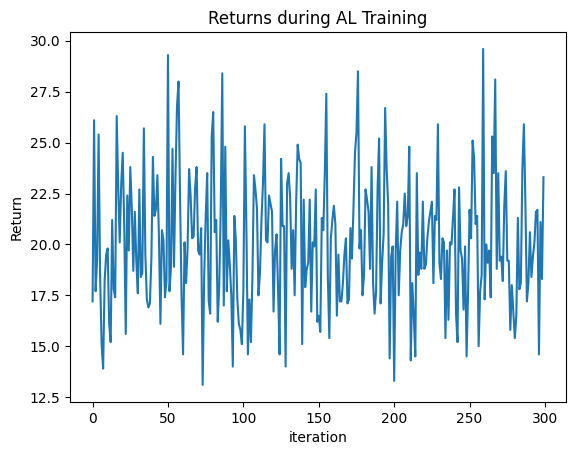

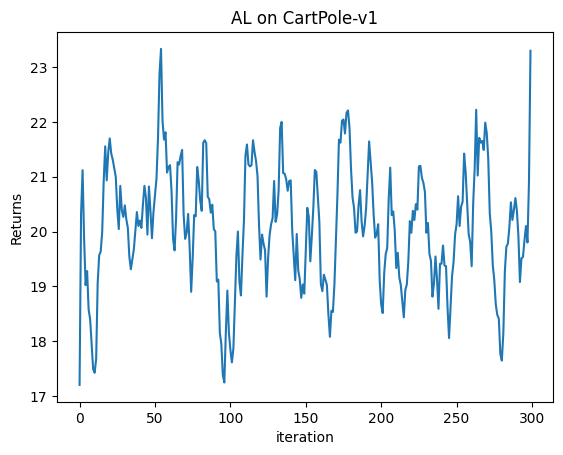

In [50]:
# 绘制结果
episodes_list = list(range(len(returns)))

plt.plot(episodes_list,returns)
plt.title('Returns during AL Training')
plt.xlabel('iteration')
plt.ylabel('Return')
plt.show()

mv_return = rl_utils.moving_average(returns, 9)
plt.plot(episodes_list,mv_return)
plt.xlabel('iteration')
plt.ylabel('Returns')
plt.title('AL on {}'.format(env_name))
plt.show()


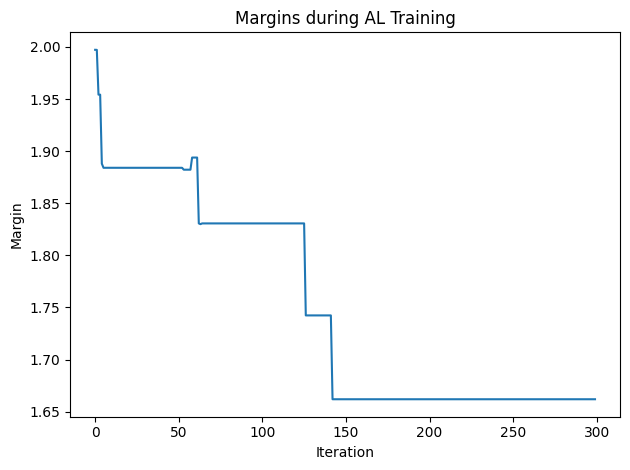

In [51]:

plt.plot(margins)
plt.title('Margins during AL Training')
plt.xlabel('Iteration')
plt.ylabel('Margin')

plt.tight_layout()
plt.show()

可以看到，策略效果非常差，原因是基函数过于简单，但是专家策略与训练策略的差距是在不断缩小的，说明算法是正确的  
线性的映射基函数不好选取